In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# @title Параметры
# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"
START = "2024-01-20"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps
EMA_FAST_PERIOD = 500
EMA_SLOW_PERIOD = 750
SPLITS = (0.8, 0.05, 0.15)

SEQ_LEN = 30
BATCH_SIZE = 512
UNITS_PER_LAYER = [160, 64, 32]
DROPOUT = 0.5
EPOCHS = 50
LR = 3e-5
GRAD_CLIP_NORM = 1.0
EARLY_STOPPING_PATIENCE = 20
LR_MODE = "onecycle"
ONECYCLE_MAX_LR = 8e-3
ONECYCLE_PCT_START = 0.5
LR_RESTART_PATIENCE = 4
LR_RESTART_SHRINK = 0.5
BEST_PATH = "best_lstm.weights.h5"

FEE = 0.0002
SLIPPAGE = 0.0001
T = None


In [2]:
!pip install optuna

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.calibrate import calibrate_model
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.q_labels_matching import enrich_q_labels_trend_one_side, soft_signal_labels_gaussian
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.visualisation import plot_enriched_actions_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.residual_lstm import build_stacked_residual_lstm
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.optuna_tuner import optimize_hyperparameters
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *

# from scr.check_data import prepare_time_series
# from scr.calibrate import calibrate_model
# from scr.q_labels_matching import enrich_q_labels_trend_one_side
# from scr.visualisation import plot_enriched_actions_one_side
# from scr.dataset_builder import DatasetBuilderForYourColumns
# from scr.residual_lstm import build_stacked_residual_lstm
# from scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
# from scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
# from scr.optuna_tuner import optimize_hyperparameters
# from scr.indicators import *


In [3]:
# Load and check data
raw_df = joblib.load(PATH_TO_DATA).loc[START:END]
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL)
print(f"From {df.index[0]} to {df.index[-1]}")


From 2024-01-20 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [4]:
# Add indicators
close = df['Close'].to_numpy(np.float64)
high = df['High'].to_numpy(np.float64)
low = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

df['EMA_fast_raw'] = ema_numba(close, EMA_FAST_PERIOD)
df['EMA_slow_raw'] = ema_numba(close, EMA_SLOW_PERIOD)
df['EMA_fast'] = ema_numba_safe(close, EMA_FAST_PERIOD)
df['EMA_slow'] = ema_numba_safe(close, EMA_SLOW_PERIOD)
df['SMA_14'] = sma_numba(close, 14)
df['ADX_14'] = adx_numba(high, low, close, 14)
df['ATR_14'] = atr_numba(high, low, close, 14)
df['RSI_14'] = rsi_numba(close, 14)
macd, macd_signal, macd_hist = macd_numba(close, 12, 26, 9)
df['MACD'] = macd
df['MACD_signal'] = macd_signal
df['MACD_hist'] = macd_hist
stoch_k, stoch_d = stoch_numba(high, low, close, 14, 3)
df['STOCH_K'] = stoch_k
df['STOCH_D'] = stoch_d
boll_mid, boll_up, boll_dn = bollinger_numba(close, 20, 2.0)
df['BOLL_MID'] = boll_mid
df['BOLL_UP'] = boll_up
df['BOLL_DN'] = boll_dn
df['OBV'] = obv_numba(close, volume)
df['CCI_20'] = cci_numba(high, low, close, 20)
df['WILLR_14'] = williams_r_numba(high, low, close, 14)
df['MFI_14'] = mfi_numba(high, low, close, volume, 14)
df['ROC_12'] = roc_numba(close, 12)
df['VWAP_20'] = vwap_numba(high, low, close, volume, 20)
piv = zigzag_pivots_highlow_numba(high, low, close, 0.05, -0.05, 3, 1)
df['Pivots'] = piv
df['Pivots_expanded'] = expand_pivots(piv, 2)


In [5]:
# Добавляем сигнал референс стратегии
buy_sig  = (df['EMA_fast'] > df['EMA_slow']) & (df['Close'] > df['EMA_fast']) & (df['ADX_14'] > 20)
sell_sig = (df['EMA_fast'] < df['EMA_slow']) & (df['Close'] < df['EMA_fast']) & (df['ADX_14'] > 20)
df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)


In [6]:
# Q-labels
# df = enrich_q_labels_trend_one_side(
#     df,

#     # mode='tdlambda',
#     # H_max = 300,
#     # lam = 0.98,

#     mode='horizon',
#     H_max = 120,

#     # mode='exit',

#     fee=FEE,
#     slippage=SLIPPAGE,
#     use_mae_penalty=False,
#     mae_lambda=10
# )

# Soft gaussian labels
df = soft_signal_labels_gaussian(
    df,
    side_long = True,
    blur_window=1000,
    blur_sigma=100,
    mae_lambda=40,

)
print(df[2500:5000].to_string())


         timestamp     Open     High      Low    Close      Volume  EMA_fast_raw  EMA_slow_raw  EMA_fast  EMA_slow    SMA_14     ADX_14    ATR_14     RSI_14          MACD   MACD_signal     MACD_hist     STOCH_K       STOCH_D  BOLL_MID   BOLL_UP   BOLL_DN          OBV      CCI_20    WILLR_14     MFI_14    ROC_12   VWAP_20  Pivots  Pivots_expanded  Signal_Rule  Pos  A_Open   A_Close    A_Hold  A_Wait
2500  1.705859e+12  0.08668  0.08674  0.08666  0.08674    229869.0      0.086901      0.086663  0.086901  0.086663  0.086771  23.091865  0.000079  52.216504  2.695511e-05  5.305780e-05 -2.610270e-05   34.782609  1.853865e+01  0.086780  0.086902  0.086657   84947625.0  -83.601286  -65.217391  58.264024 -0.161142  0.086782       0                0            0    1     0.0  0.312319  0.687681     0.0
2501  1.705859e+12  0.08677  0.08680  0.08676  0.08677    258858.0      0.086900      0.086664  0.086900  0.086664  0.086766  22.187457  0.000078  54.461747  2.707269e-05  4.786078e-05 -2.078809e-

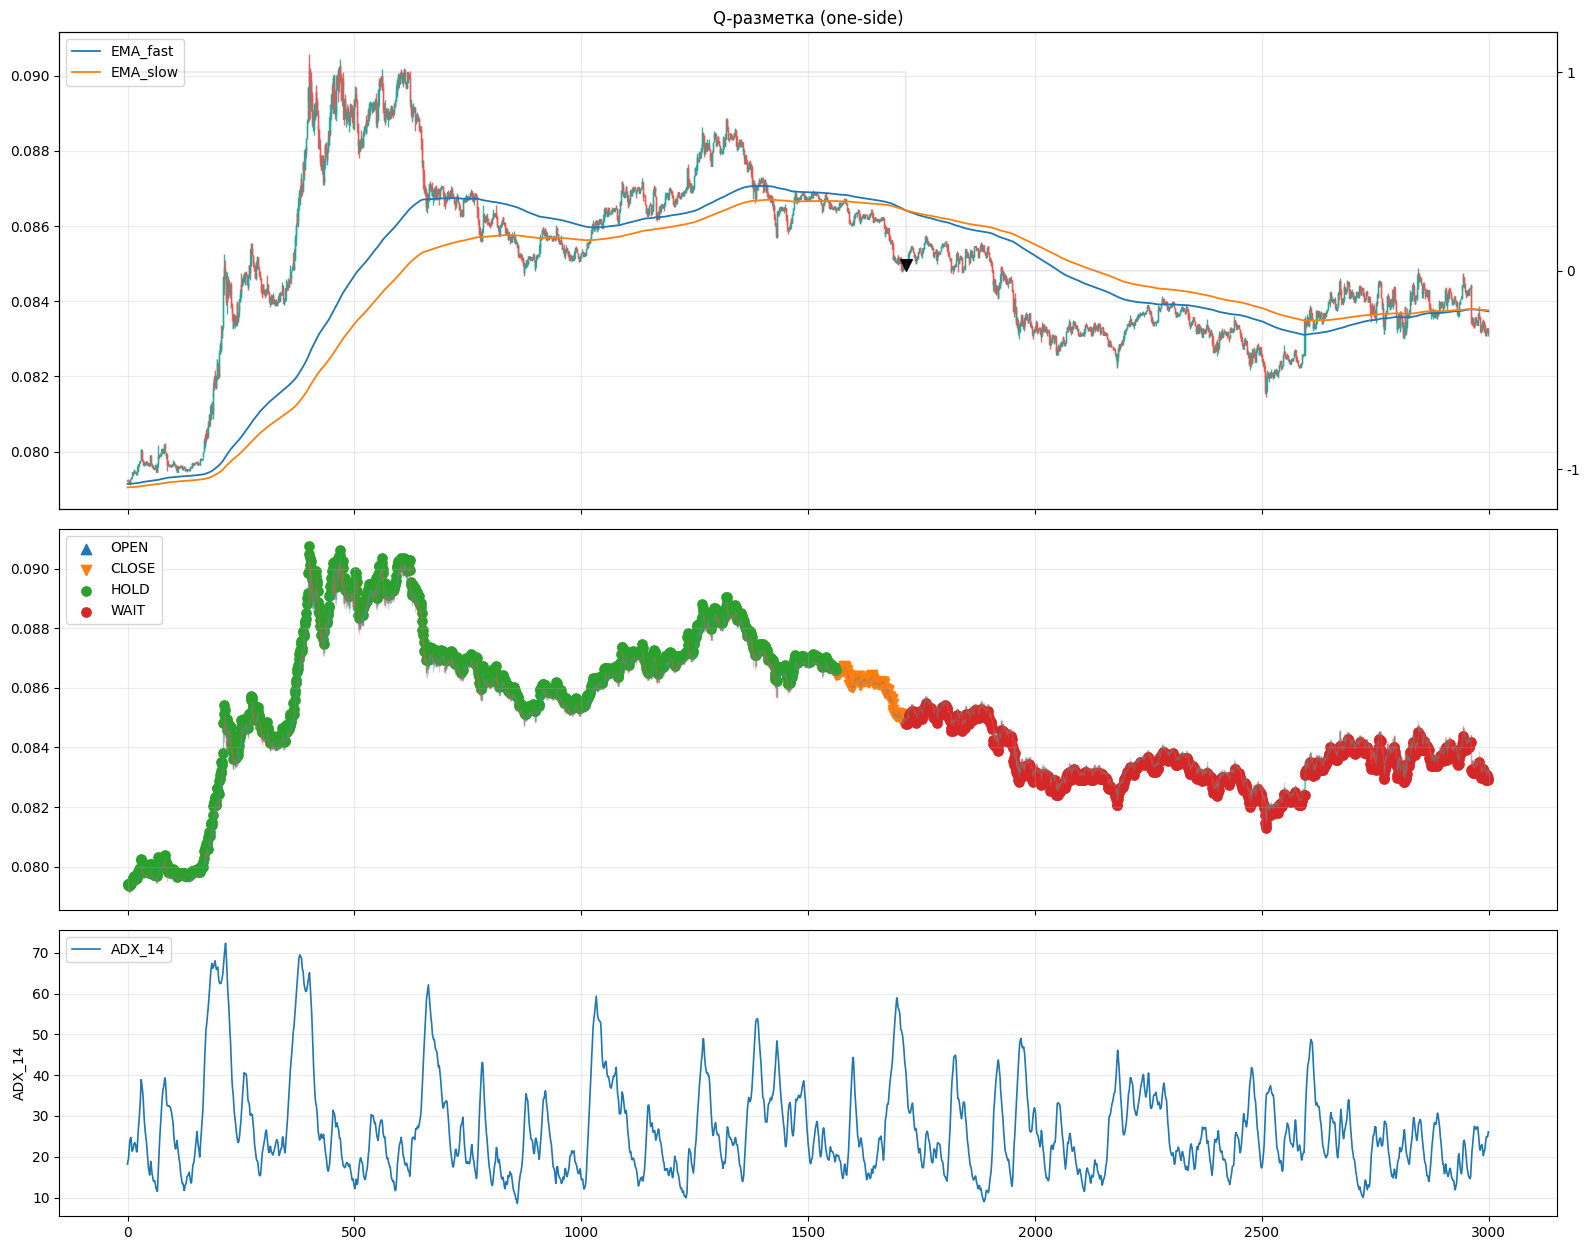

In [7]:
# Visualisation
plot_enriched_actions_one_side(
    df,
    start=1000,
    end=4000,
    indicators_price={
        'EMA_fast':df['EMA_fast'],
        'EMA_slow':df['EMA_slow'],
        },
    indicators_panels={
        'ADX_14':df['ADX_14'],
    }
)


In [8]:
# @title Нормализация и нарезка данных
enriched = df
builder = DatasetBuilderForYourColumns(
    seq_len=SEQ_LEN, norm="minmax",
    labels_from="a", # change to "q" if use q-labels
    tau=1, r_mode="oracle",
    splits=SPLITS,
    batch_size=BATCH_SIZE,
    sw_mode="ClassBalance",
    drop_cols=["timestamp", "BarsToExit_Open", "BarsToExit_Hold", "Signal_Rule", "Pos", "Pivots", "Pivots_expanded" ],
)
splits = builder.fit_transform(enriched, return_indices=True)
train_ds, val_ds, test_ds = builder.as_tf_datasets(splits)
test_idx = splits["test"][-1]


In [ ]:
xb, play_off = next(iter(train_ds.take(1)))
Y,_,_,_,_ = play_off
Y

<tf.Tensor: shape=(512, 4), dtype=float32, numpy=
array([[4.5860067e-02, 0.0000000e+00, 0.0000000e+00, 9.5413995e-01],
       [8.7444967e-01, 0.0000000e+00, 0.0000000e+00, 1.2555031e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       ...,
       [0.0000000e+00, 2.3908046e-01, 7.6091951e-01, 0.0000000e+00],
       [6.4265665e-10, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00]],
      dtype=float32)>

In [ ]:
# @title Оптимизация гиперпараметров

xb, _ = next(iter(train_ds.take(1)))
feature_dim = xb.shape[-1]
best_params = optimize_hyperparameters(
    train_ds,
    val_ds,
    seq_len=SEQ_LEN,
    feature_dim=feature_dim,
    n_trials=10,
    epochs=5,
)
UNITS_PER_LAYER = best_params['units_per_layer']
DROPOUT = best_params['dropout']
LR = best_params['lr']


[I 2025-08-31 20:17:33,393] A new study created in memory with name: no-name-ecab4769-3d93-4957-b8c4-f7d8da733b9a


Epoch 01 | train: loss 0.6799, acc 0.5967, ER 0.000000 | val: loss 0.6227, acc 0.6167, macroF1 0.2833, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 02 | train: loss 0.6454, acc 0.6280, ER 0.000000 | val: loss 0.5993, acc 0.6564, macroF1 0.3289, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 03 | train: loss 0.6316, acc 0.6431, ER 0.000000 | val: loss 0.5756, acc 0.6597, macroF1 0.3261, ER 0.000000, ICp 0.0000, ICs 1.0000


[I 2025-08-31 20:21:58,298] Trial 0 finished with value: 0.5795610547065735 and parameters: {'units_l1': 96, 'units_l2': 256, 'units_l3': 192, 'dropout': 0.3394633936788146, 'lr': 2.9380279387035334e-05}. Best is trial 0 with value: 0.5795610547065735.


Epoch 04 | train: loss 0.6181, acc 0.6603, ER 0.000000 | val: loss 0.5796, acc 0.6932, macroF1 0.3408, ER 0.000000, ICp 0.0000, ICs 1.0000
Early stopping: no improvement for 1 epochs.
Restored best weights from best_lstm.weights.h5
Epoch 01 | train: loss 0.6422, acc 0.6363, ER 0.000000 | val: loss 0.5657, acc 0.6777, macroF1 0.3252, ER 0.000000, ICp 0.0000, ICs 1.0000


[I 2025-08-31 20:23:16,511] Trial 1 finished with value: 0.5888262391090393 and parameters: {'units_l1': 64, 'units_l2': 32, 'units_l3': 224, 'dropout': 0.34044600469728353, 'lr': 0.001331121608073689}. Best is trial 0 with value: 0.5795610547065735.


Epoch 02 | train: loss 0.6217, acc 0.6641, ER 0.000000 | val: loss 0.5888, acc 0.7371, macroF1 0.3291, ER 0.000000, ICp 0.0000, ICs 1.0000
Early stopping: no improvement for 1 epochs.
Restored best weights from best_lstm.weights.h5
Epoch 01 | train: loss 0.6565, acc 0.6197, ER 0.000000 | val: loss 0.5880, acc 0.6901, macroF1 0.3462, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 02 | train: loss 0.6280, acc 0.6476, ER 0.000000 | val: loss 0.5326, acc 0.7202, macroF1 0.3510, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 03 | train: loss 0.6142, acc 0.6656, ER 0.000000 | val: loss 0.5311, acc 0.7150, macroF1 0.3383, ER 0.000000, ICp 0.0000, ICs 1.0000


[I 2025-08-31 20:27:17,448] Trial 2 finished with value: 0.5365324020385742 and parameters: {'units_l1': 32, 'units_l2': 256, 'units_l3': 224, 'dropout': 0.18493564427131048, 'lr': 3.511356313970405e-05}. Best is trial 2 with value: 0.5365324020385742.


Epoch 04 | train: loss 0.6041, acc 0.6782, ER 0.000000 | val: loss 0.5365, acc 0.7126, macroF1 0.3314, ER 0.000000, ICp 0.0000, ICs 1.0000
Early stopping: no improvement for 1 epochs.
Restored best weights from best_lstm.weights.h5
Epoch 01 | train: loss 0.6598, acc 0.6116, ER 0.000000 | val: loss 0.5913, acc 0.6543, macroF1 0.3229, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 02 | train: loss 0.6274, acc 0.6491, ER 0.000000 | val: loss 0.5598, acc 0.6592, macroF1 0.2992, ER 0.000000, ICp 0.0000, ICs 1.0000


[I 2025-08-31 20:29:14,403] Trial 3 finished with value: 0.5607482194900513 and parameters: {'units_l1': 64, 'units_l2': 96, 'units_l3': 160, 'dropout': 0.2727780074568463, 'lr': 7.476312062252303e-05}. Best is trial 2 with value: 0.5365324020385742.


Epoch 03 | train: loss 0.6082, acc 0.6714, ER 0.000000 | val: loss 0.5607, acc 0.6921, macroF1 0.3392, ER 0.000000, ICp 0.0000, ICs 1.0000
Early stopping: no improvement for 1 epochs.
Restored best weights from best_lstm.weights.h5


Epoch 01 | train: loss 0.6417, acc 0.6361, ER 0.000000 | val: loss 0.5678, acc 0.6974, macroF1 0.3341, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 02 | train: loss 0.6158, acc 0.6683, ER 0.000000 | val: loss 0.5450, acc 0.6408, macroF1 0.2765, ER 0.000000, ICp 0.0000, ICs 1.0000


[I 2025-08-31 20:31:14,808] Trial 4 finished with value: 0.5490463972091675 and parameters: {'units_l1': 160, 'units_l2': 64, 'units_l3': 96, 'dropout': 0.2465447373174767, 'lr': 0.00023345864076016249}. Best is trial 2 with value: 0.5365324020385742.


Epoch 03 | train: loss 0.6034, acc 0.6861, ER 0.000000 | val: loss 0.5490, acc 0.6693, macroF1 0.3096, ER 0.000000, ICp 0.0000, ICs 1.0000
Early stopping: no improvement for 1 epochs.
Restored best weights from best_lstm.weights.h5
Epoch 01 | train: loss 0.7037, acc 0.5786, ER 0.000000 | val: loss 0.6228, acc 0.6521, macroF1 0.2543, ER 0.000000, ICp 0.0000, ICs 1.0000


[I 2025-08-31 20:33:00,929] Trial 5 finished with value: 0.6316773891448975 and parameters: {'units_l1': 224, 'units_l2': 64, 'units_l3': 160, 'dropout': 0.33696582754481696, 'lr': 1.3783237455007187e-05}. Best is trial 2 with value: 0.5365324020385742.


Epoch 02 | train: loss 0.6669, acc 0.6029, ER 0.000000 | val: loss 0.6317, acc 0.6593, macroF1 0.2908, ER 0.000000, ICp 0.0000, ICs 1.0000
Early stopping: no improvement for 1 epochs.
Restored best weights from best_lstm.weights.h5


Epoch 01 | train: loss 0.6534, acc 0.6190, ER 0.000000 | val: loss 0.6030, acc 0.6346, macroF1 0.2743, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 02 | train: loss 0.6311, acc 0.6447, ER 0.000000 | val: loss 0.5542, acc 0.6834, macroF1 0.3124, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 03 | train: loss 0.6082, acc 0.6753, ER 0.000000 | val: loss 0.5033, acc 0.7488, macroF1 0.3572, ER 0.000000, ICp 0.0000, ICs 1.0000


[I 2025-08-31 20:35:23,785] Trial 6 finished with value: 0.5336064100265503 and parameters: {'units_l1': 160, 'units_l2': 64, 'units_l3': 32, 'dropout': 0.4795542149013333, 'lr': 0.00788671412999049}. Best is trial 6 with value: 0.5336064100265503.


Epoch 04 | train: loss 0.5923, acc 0.6988, ER 0.000000 | val: loss 0.5336, acc 0.7421, macroF1 0.3506, ER 0.000000, ICp 0.0000, ICs 1.0000
Early stopping: no improvement for 1 epochs.
Restored best weights from best_lstm.weights.h5
Epoch 01 | train: loss 0.6497, acc 0.6236, ER 0.000000 | val: loss 0.5925, acc 0.6104, macroF1 0.2348, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 02 | train: loss 0.6236, acc 0.6577, ER 0.000000 | val: loss 0.5402, acc 0.6746, macroF1 0.2994, ER 0.000000, ICp 0.0000, ICs 1.0000


[I 2025-08-31 20:37:44,025] Trial 7 finished with value: 0.5513321161270142 and parameters: {'units_l1': 224, 'units_l2': 96, 'units_l3': 32, 'dropout': 0.3736932106048628, 'lr': 0.00020914981329035596}. Best is trial 6 with value: 0.5336064100265503.


Epoch 03 | train: loss 0.6085, acc 0.6770, ER 0.000000 | val: loss 0.5513, acc 0.7041, macroF1 0.3306, ER 0.000000, ICp 0.0000, ICs 1.0000
Early stopping: no improvement for 1 epochs.
Restored best weights from best_lstm.weights.h5
Epoch 01 | train: loss 0.6952, acc 0.5773, ER 0.000000 | val: loss 0.6310, acc 0.6698, macroF1 0.2981, ER 0.000000, ICp 0.0000, ICs 1.0000


In [ ]:
# @title Обучение модели
xb, _ = next(iter(train_ds.take(1)))
model = build_stacked_residual_lstm(seq_len=xb.shape[1], feature_dim=xb.shape[-1],
                                    units_per_layer=UNITS_PER_LAYER, dropout=DROPOUT)

history = fit_model(
    model,
    train_ds,
    val_ds,
    epochs=EPOCHS,
    steps_per_epoch=None,
    lr=LR,
    grad_clip_norm=GRAD_CLIP_NORM,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    lr_mode=LR_MODE,
    onecycle_max_lr=ONECYCLE_MAX_LR,
    onecycle_pct_start=ONECYCLE_PCT_START,
    lr_restart_patience=LR_RESTART_PATIENCE,
    lr_restart_shrink=LR_RESTART_SHRINK,
    best_path=BEST_PATH,
)

plot_history_curves(history)


Epoch 01 | train: loss 0.6949, acc 0.5155, ER -0.000020 | val: loss 0.6930, acc 0.5178, macroF1 0.2268, ER -0.000118, ICp 0.0983, ICs 0.8128
Epoch 02 | train: loss 0.6929, acc 0.5187, ER -0.000019 | val: loss 0.6930, acc 0.5188, macroF1 0.2298, ER -0.000118, ICp 0.0983, ICs 0.8129
Epoch 03 | train: loss 0.6928, acc 0.5201, ER -0.000019 | val: loss 0.6930, acc 0.5048, macroF1 0.2058, ER -0.000118, ICp 0.0982, ICs 0.8129
Epoch 04 | train: loss 0.6928, acc 0.5202, ER -0.000019 | val: loss 0.6931, acc 0.5048, macroF1 0.2058, ER -0.000118, ICp 0.0984, ICs 0.8131
Epoch 05 | train: loss 0.6928, acc 0.5201, ER -0.000019 | val: loss 0.6931, acc 0.5048, macroF1 0.2058, ER -0.000118, ICp 0.0983, ICs 0.8130
[LR-RESTART] New cycle with factor=0.500


In [ ]:
# Loading weights
model.load_weights(BEST_PATH)

In [ ]:
# 3) оценка на тесте
test_metrics = evaluate_dataset(model, test_ds)
print("TEST METRICS:")
for k,v in  materialize_metrics(test_metrics).items():
  print(f"{k}:{v}")


TEST METRICS:
loss:0.6924980878829956
acc:0.5107857584953308
macro_f1:0.25894638895988464
f1_per_class:[0.0, 0.3663076162338257, 0.24185879528522491, 0.42761915922164917]
exp_return:-0.00012261496158316731
oracle_ER:0.003414076752960682
ER_ratio:-0.035914529114961624
IC_pearson:0.18457332253456116
IC_spearman:0.837997317314148


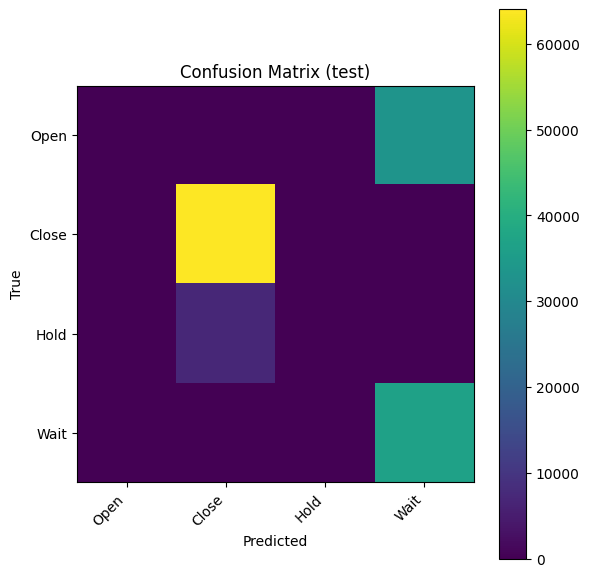

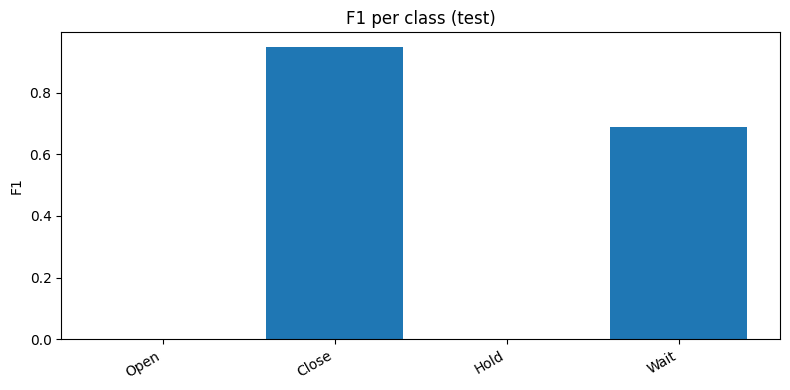

In [ ]:
# 4) конфьюжн-матрица и F1 per class на тесте
cm_test, f1_test = confusion_and_f1_on_dataset(model, test_ds)

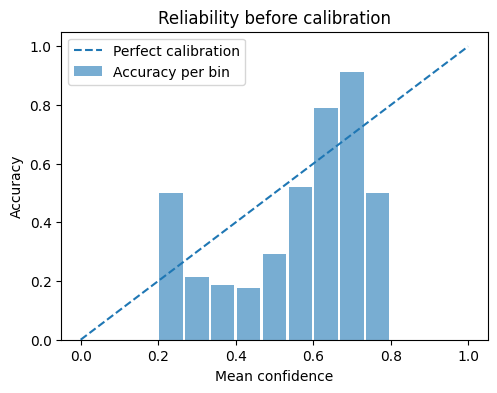

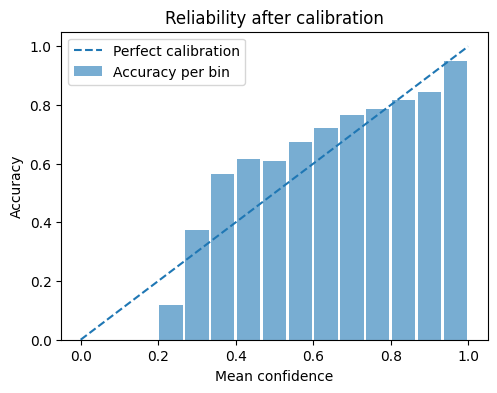

NLL before: 1.281526 | ECE before: 0.179047
NLL after:  1.116044 | ECE after:  0.104243
Temperature T: [153.56932   23.07552   31.662636   0.368572]
Saved: artifacts/calibration/temperature.json
Температуры:  [153.56932067871094, 23.075519561767578, 31.662635803222656, 0.3685719966888428]


In [ ]:
# Калибровка модели
calib_info = calibrate_model(model, val_ds, per_class=True, init_T=1.0, plot=True)
T = calib_info['T']
print("Температуры: ", T)


Метрики референс стратегии:
Equity: 0.3085
Realized PnL: 0.3085
Closed trades: 68
Win rate: 29.41%
Avg PnL per trade: 0.0046
Profit factor: 1.4405
Max drawdown: 7.3329
Sharpe ratio: 0.8318

Метрики модели:
Equity: 0.0000
Realized PnL: 0.0000
Closed trades: 0
Win rate: 0.00%
Avg PnL per trade: 0.0000
Profit factor: 0.0000
Max drawdown: 0.0000
Sharpe ratio: 0.0000


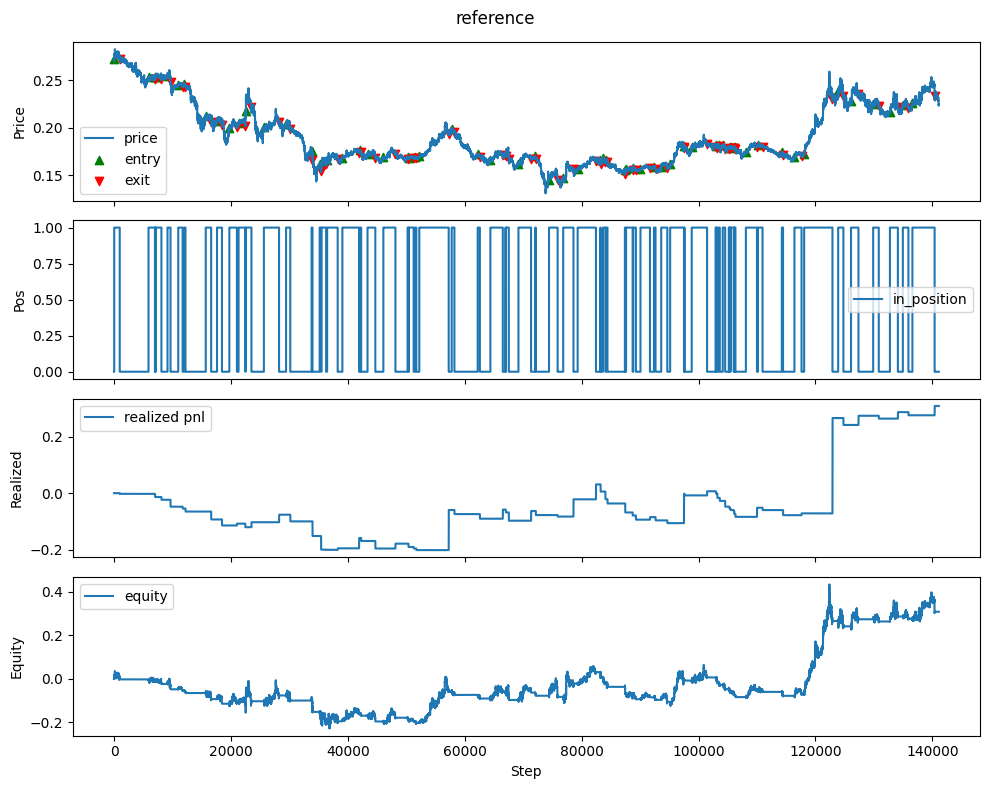

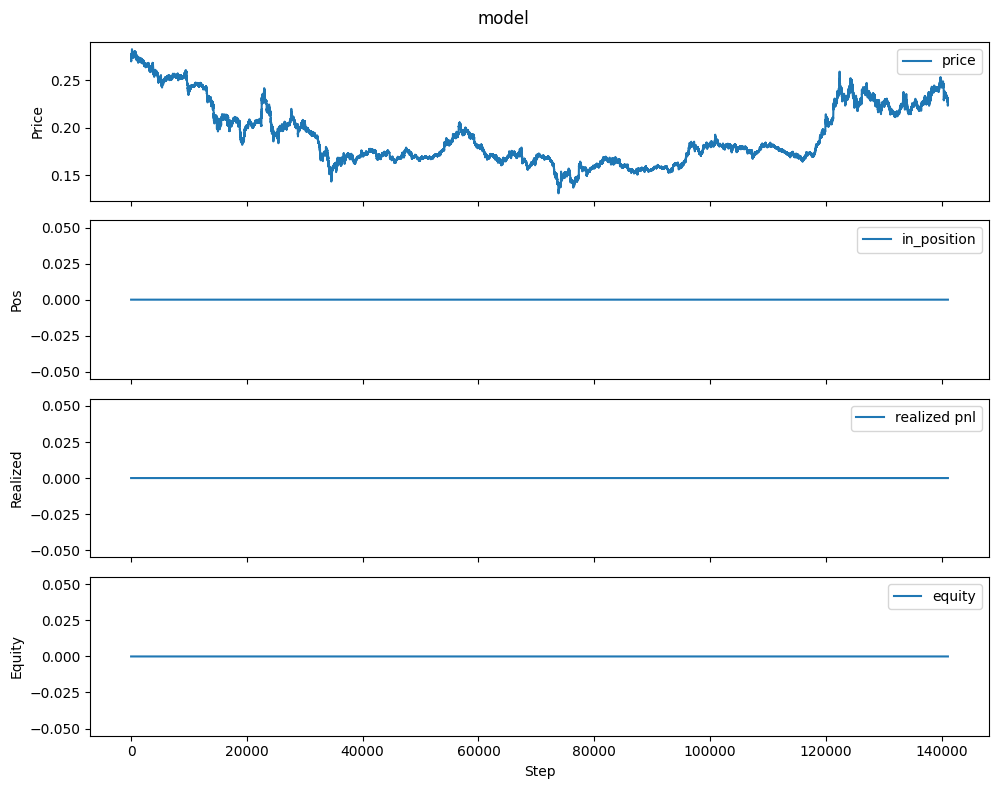

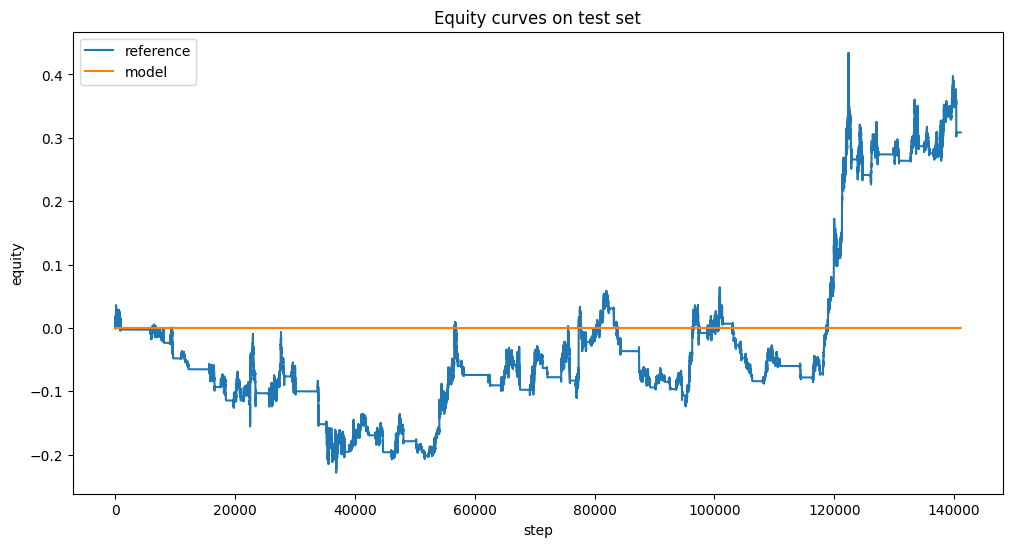

In [ ]:
#Запуск бэктестов: референс стратегия, модель, учитель

def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['Signal_Rule'].iloc[:-1]:
        pos = env.position
        if sig == 1:
            action = 0 # OPEN
        elif sig == -1:
            action = 1 # CLOSE
        else:
            action = 2 if pos == 1 else 3 # HOLD or WAIT
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.0002,         # без комиссии
    spread=0.0001,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

start, end = int(test_idx[0]), int(test_idx[-1])
df_bt = enriched.iloc[start:end+2].copy()

env_ref = BacktestEnv(df_bt, feature_cols=['EMA_fast', 'EMA_slow'], cfg=LONG_CONFIG, price_col='Open')
sim_ref = run_backtest(df_bt, env_ref)
sim_ref.plot("reference")
print('Метрики референс стратегии:')
print(sim_ref.metrics_report())

logits = predict_logits_dataset(model, test_ds)
logits_cal = logits / T if T is not None else logits
env_model = run_backtest_with_logits(enriched, logits_cal, test_idx, feature_cols=['EMA_fast', 'EMA_slow'], price_col='Open', cfg=LONG_CONFIG)
env_model.plot("model")
print('\nМетрики модели:')
print(env_model.metrics_report())

# W_test = splits['test'][3]
# env_teacher = run_backtest_with_logits(enriched, W_test, test_idx, feature_cols=['EMA_fast', 'EMA_slow'], price_col='Open', cfg=LONG_CONFIG)
# env_teacher.plot("teacher")
# print('\nМетрики учителя:')
# print(env_teacher.metrics_report())

log_ref = sim_ref.logs()
log_model = env_model.logs()
# log_teacher = env_teacher.logs()
plt.figure(figsize=(12,6))
plt.plot(log_ref['equity'], label='reference')
plt.plot(log_model['equity'], label='model')
# plt.plot(log_teacher['equity'], label='teacher')
plt.legend()
plt.title('Equity curves on test set')
plt.xlabel('step')
plt.ylabel('equity')
plt.show()
